In [74]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [75]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
reload(hyperparams)
params = hyperparams.Hyperparams
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)
import utils
reload(utils)

<module 'utils' from '/home/aduriseti/tts/ettts/utils.py'>

In [76]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [77]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [112]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev)
else:
    # COLD START - RESET text2Mel
    text2Mel = dcttsModel.Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
LOADED EPOCH 111, LOSS 0.025353407648517123, BEST LOSS 0.025353407648517123 FROM


In [113]:
len(lossHist)

112

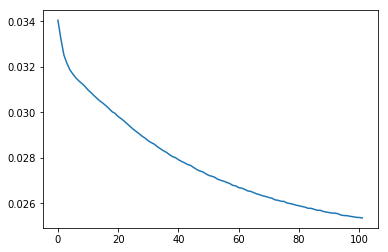

In [114]:
plt.plot(lossHist[10:])

In [115]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = dcttsModel.SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 1
if load:
    startEpoch,lossHist,bestLoss = utils.loadChkpt(ssrn,ssrnOpt,'ssrn',dev)
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

HYPERPARAMS sep:0|alpha:1|dropout:False|norm:1|lr:0.001|chunk:1
LOADED EPOCH 46, LOSS 0.09984890006816209, BEST LOSS 0.09984890006816209 FROM


In [116]:
len(lossHist)

47

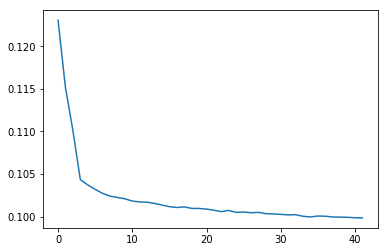

In [117]:
plt.plot(lossHist[5:])

In [118]:
print(ch.cuda.is_available())
print(dev)
dev = 'cpu'
print(dev)
text2Mel = text2Mel.eval().to(dev)
# audioDec = audioDec.eval().to(dev)
ssrn = ssrn.eval().to(dev)

True
cpu
cpu


In [119]:
# # text = "Bears. Beets. Battlestar Galactica".lower()
# text = "four score and seven years ago".lower()
# # text = "how cow brown now".lower()
# # “In nineteen seventy two, a crack commando unit was sent to prison by a military court for a crime they didn’t commit.”
# # “These men promptly escaped from the maximum security stockage to the Los Angeles underground.”
# # “Today, still wanted by the government, they survive as soldiers of fortune.”
# # “If you have a problem, if no-one else can help, and if you can find them.”
# # “Maybe you can hire, the A-Team.”
# L = ch.Tensor([params.c2i[c] for c in text])
# L = ch.cat((L,ch.zeros(180-L.shape[0])))
# L = L.type(ch.LongTensor).to(dev).unsqueeze(0)
# L.shape

In [120]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(100)
L,S,Y = L.unsqueeze(0),S.unsqueeze(0),Y.unsqueeze(0)
L.shape,S.shape,Y.shape

(torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]))

In [121]:
# initial audio enc
# S = ch.zeros((80,217)).to(dev).unsqueeze(0)
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
Shat = s0

In [122]:
with ch.no_grad():
    for t in tqdm.tqdm_notebook(range(100)):
        Snext,A = text2Mel(L,Shat[:,:,-100:])
#         S[:,:,t+1 ] = Shat[:,:,t]
        Shat = ch.cat((s0,Snext),dim=2)
#         S = ch.cat((S,Shat[:,:,-1:]),dim=2)

In [123]:
Yhat = ssrn(Shat)

In [124]:
def toAudio(Y):
    T = Y ** (params.eta / params.gamma) * 50
    T = T.cpu().detach().numpy().astype(np.float64)
    T = T[0].T
    T[T<0] = 0

    lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
    T = lwsProc.run_lws(T)
    T = lwsProc.istft(T)
    return T

In [125]:
ipd.Audio(toAudio(Y),rate=22050)

In [126]:
ipd.Audio(toAudio(Yhat),rate=22050)

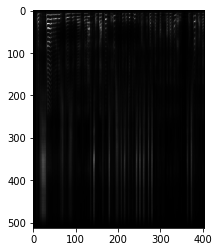

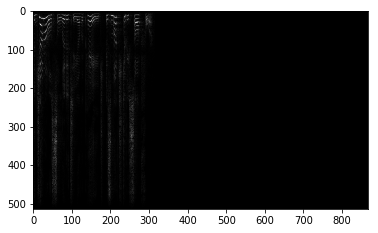

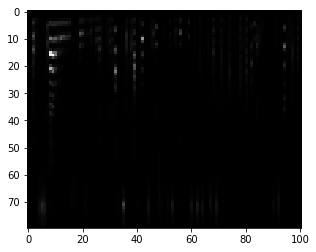

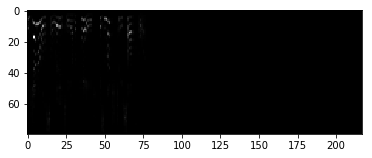

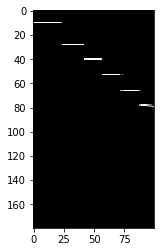

In [129]:
plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(Y[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()